# Credit Risk Model - Logistic Regression

In [1]:
# Libraries

import pandas as pd # manipulação de dado em formato de dataframe
import seaborn as sns # biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import statsmodels.api as sm # biblioteca de modelagem estatística
import numpy as np # biblioteca para operações matemáticas multidimensionais
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
import plotly.graph_objs as go # gráfico 3D
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # stepwise
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score # matriz de confusão
from sklearn.metrics import roc_curve, auc # curva roc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset

df = pd.read_csv("df.credit.risk.csv", encoding = "utf-8")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28501 entries, 0 to 28500
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28501 non-null  int64  
 1   person_income               28501 non-null  int64  
 2   person_home_ownership       28501 non-null  object 
 3   person_emp_length           28501 non-null  float64
 4   loan_intent                 28501 non-null  object 
 5   loan_grade                  28501 non-null  object 
 6   loan_amnt                   28501 non-null  int64  
 7   loan_int_rate               28501 non-null  float64
 8   loan_percent_income         28501 non-null  float64
 9   cb_person_default_on_file   28501 non-null  object 
 10  cb_person_cred_hist_length  28501 non-null  int64  
 11  default                     28501 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.6+ MB


## Preparação do dataset

In [3]:
# Fazendo a contagem da variável target

# Contagem absoluta
abs_count = df['default'].value_counts()

# Contagem relativa
rel_count = df['default'].value_counts(normalize=True)

# Concatenar as duas séries de dados
result = pd.concat([rel_count, abs_count], axis=1)

# Renomear as colunas
result.columns = ['Proporção', 'Contagem']

# Ordenar os valores pela contagem absoluta
result = result.sort_values(by='Contagem', ascending=False)

# Imprimir o resultado
print(result)

   Proporção  Contagem
0   0.782885     22313
1   0.217115      6188


In [21]:
# Outra forma de verificar a proporção da variável target
default_count = df[df["default"] == 1]["default"].count()
n_default_count = df[df["default"] == 0]["default"].count()
print("Numero de default:", default_count)
print("Numero de nao default", n_default_count)
print("Percentual de default:", default_count / (default_count + n_default_count) * 100)

Numero de default: 6188
Numero de nao default 22313
Percentual de default: 21.71151889407389


<BarContainer object of 1 artists>

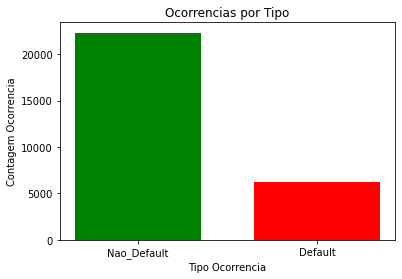

In [22]:
# Visualização Gráfica
categories = ["Nao_Default", "Default"]
xpos = np.array([0, 1])
plt.xticks(xpos, categories)
plt.xlabel("Tipo Ocorrencia")
plt.ylabel("Contagem Ocorrencia")
plt.title("Ocorrencias por Tipo")
plt.bar(xpos[0], n_default_count, width= 0.7, color = "g")
plt.bar(xpos[1], default_count, width = 0.7, color="r")

In [4]:
# Transformação das variáveis categóricas não binárias em dummies

# Verificando a quantidade de categorias das variáveis 
df['person_home_ownership'].value_counts()
df['loan_intent'].value_counts()
df['loan_grade'].value_counts()
df['cb_person_default_on_file'].value_counts()

# get dummies
df_dummies = pd.get_dummies(df,
                            columns=['person_home_ownership',
                                     'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                                      drop_first=True)

df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28501 entries, 0 to 28500
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   28501 non-null  int64  
 1   person_income                28501 non-null  int64  
 2   person_emp_length            28501 non-null  float64
 3   loan_amnt                    28501 non-null  int64  
 4   loan_int_rate                28501 non-null  float64
 5   loan_percent_income          28501 non-null  float64
 6   cb_person_cred_hist_length   28501 non-null  int64  
 7   default                      28501 non-null  int64  
 8   person_home_ownership_OTHER  28501 non-null  uint8  
 9   person_home_ownership_OWN    28501 non-null  uint8  
 10  person_home_ownership_RENT   28501 non-null  uint8  
 11  loan_intent_EDUCATION        28501 non-null  uint8  
 12  loan_intent_HOMEIMPROVEMENT  28501 non-null  uint8  
 13  loan_intent_MEDI

## Estimação do modelo logístico binário

In [5]:
# Definição da fórmula utilizada no modelo
lista_colunas = list(df_dummies.drop(columns=['default']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "default ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  default ~ person_age + person_income + person_emp_length + loan_amnt + loan_int_rate + loan_percent_income + cb_person_cred_hist_length + person_home_ownership_OTHER + person_home_ownership_OWN + person_home_ownership_RENT + loan_intent_EDUCATION + loan_intent_HOMEIMPROVEMENT + loan_intent_MEDICAL + loan_intent_PERSONAL + loan_intent_VENTURE + loan_grade_B + loan_grade_C + loan_grade_D + loan_grade_E + loan_grade_F + loan_grade_G + cb_person_default_on_file_Y


In [6]:
# Modelo
modelo_credito = sm.Logit.from_formula(formula_dummies_modelo, 
                                       df_dummies).fit()

# Parâmetros do modelo
modelo_credito.summary()

Optimization terminated successfully.
         Current function value: 0.335702
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                28501
Model:                          Logit   Df Residuals:                    28478
Method:                           MLE   Df Model:                           22
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:                  0.3584
Time:                        19:34:32   Log-Likelihood:                -9567.9
converged:                       True   LL-Null:                       -14913.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.1288      0.200    -20.695      0.000      -4.520      -3.738
person_age                     -0.0125      0.006     -1.995      0.046      -0.025      -0.000
person_income                8.763e-07   3.22e-07      2.723      0.006    2.46e-07    1.51e-06
person_emp_length              -0.0142      0.005     -2.831      0.005      -0.024      -0.004
loan_amnt                      -0.0001   4.29e-06    -23.511      0.000      -0.000   -9.24e-05
loan_int_rate                   0.0892      0.018      4.910      0.000       0.054       0.125
loan_percent_income            13.1512      0.252     52.208      0.000      12.657      13.645
cb_person_cred_hist_length      0.0105      0.009      1.113      0.266      -0.008       0.029
person_home_ownership_OTHER     0.4388      0.302      1.451      0.147      -0.154       1.031
person_home_ownership_OWN      -1.7874      0.113    -15.811      0.000      -2.009      -1.566
person_home_ownership_RENT      0.8258      0.043     19.212      0.000       0.742       0.910
loan_intent_EDUCATION          -0.8755      0.061    -14.310      0.000      -0.995      -0.756
loan_intent_HOMEIMPROVEMENT     0.0485      0.068      0.714      0.475      -0.085       0.182
loan_intent_MEDICAL            -0.1569      0.058     -2.715      0.007      -0.270      -0.044
loan_intent_PERSONAL           -0.6437      0.062    -10.300      0.000      -0.766      -0.521
loan_intent_VENTURE            -1.1430      0.067    -17.146      0.000      -1.274      -1.012
loan_grade_B                    0.1085      0.083      1.308      0.191      -0.054       0.271
loan_grade_C                    0.2372      0.125      1.901      0.057      -0.007       0.482
loan_grade_D                    2.3284      0.157     14.856      0.000       2.021       2.636
loan_grade_E                    2.4932      0.198     12.611      0.000       2.106       2.881
loan_grade_F                    2.7882      0.273     10.208      0.000       2.253       3.324
loan_grade_G                    6.3306      1.056      5.996      0.000       4.261       8.400
cb_person_default_on_file_Y     0.0216      0.053      0.407      0.684      -0.083       0.126
===============================================================================================
"""

## Procedimento Stepwise

In [7]:
# Estimação do modelo por meio do procedimento Stepwise
step_modelo_credito = stepwise(modelo_credito, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 default ~ person_age + person_income + person_emp_length + loan_amnt + loan_int_rate + loan_percent_income + cb_person_cred_hist_length + person_home_ownership_OTHER + person_home_ownership_OWN + person_home_ownership_RENT + loan_intent_EDUCATION + loan_intent_HOMEIMPROVEMENT + loan_intent_MEDICAL + loan_intent_PERSONAL + loan_intent_VENTURE + loan_grade_B + loan_grade_C + loan_grade_D + loan_grade_E + loan_grade_F + loan_grade_G + cb_person_default_on_file_Y
Optimization terminated successfully.
         Current function value: 0.335702
         Iterations 8

 Discarding atribute "cb_person_default_on_file_Y" with p-value equal to 0.6843620996953588 

Estimating model...: 
 default ~ person_age + person_income + person_emp_length + loan_amnt + loan_int_rate + loan_percent_income + cb_person_cred_hist_length + person_home_ownership_OTHER + person_home_ownership_OWN + person_home_ownership_RENT + loan_intent_EDUCATION + loan_intent_HOMEIMP

In [8]:
# In[ ]: Comparando os parâmetros dos modelos

summary_col([modelo_credito, step_modelo_credito],
            model_names=["MODELO INICIAL","MODELO STEPWISE"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO INICIAL,MODELO STEPWISE
Intercept,-4.1288***,-4.4405***
,(0.1995),(0.1356)
cb_person_cred_hist_length,0.0105,
,(0.0095),
cb_person_default_on_file_Y,0.0216,
,(0.0532),
loan_amnt,-0.0001***,-0.0001***
,(0.0000),(0.0000)
loan_grade_B,0.1085,
,(0.0830),


In [9]:
# In[ ]: Construção de função para a definição da matriz de confusão

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

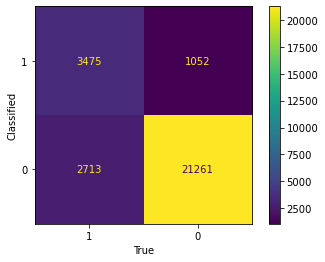

,Sensitividade,Especificidade,Acurácia
0,0.561571,0.952853,0.867899


In [10]:
# In[ ]: Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_dummies['phat'] = step_modelo_credito.predict()

#Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_dummies['default'],
                predicts=df_dummies['phat'],
                cutoff=0.50)

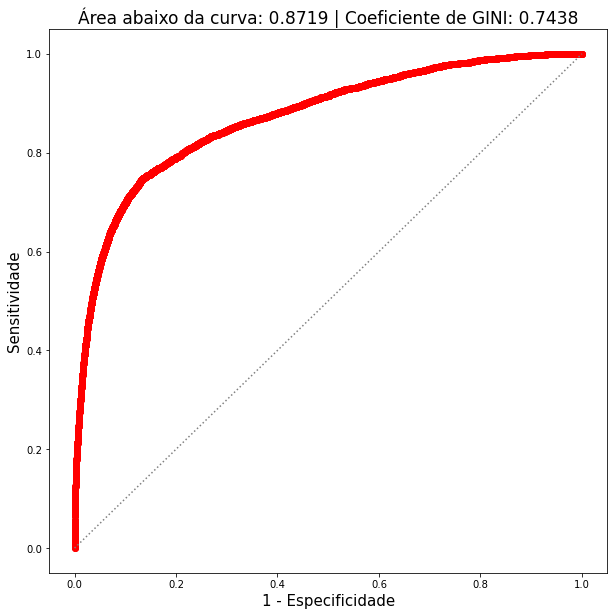

In [11]:
# In[ ]: Construção da curva ROC

#Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_dummies['default'],
                                df_dummies['phat'])
roc_auc = auc(fpr, tpr)

#Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

#Plotando a curva ROC
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr, '-o', color='red')
plt.plot(fpr,fpr, ':', color='gray')
plt.title('Área abaixo da curva: %g' % round(roc_auc,4) +
          ' | Coeficiente de GINI: %g' % round(gini,4), fontsize=17)
plt.xlabel('1 - Especificidade', fontsize=15)
plt.ylabel('Sensitividade', fontsize=15)
plt.show()

In [12]:
# In[ ]: Igualando critérios de especificidade e de sensitividade

#Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

#ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA o procedimento garante a maximização da acurácia do modelo!

#Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [18]:
# In[ ]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados

dados_plotagem = espec_sens(observado = df_dummies['default'],
                            predicts = df_dummies['phat'])

dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,0.999030,0.062968
2,0.02,0.991435,0.160982
3,0.03,0.978830,0.254291
4,0.04,0.961700,0.333169
...,...,...,...
96,0.96,0.056076,0.999776
97,0.97,0.042986,0.999821
98,0.98,0.028604,0.999910
99,0.99,0.014383,0.999910


In [19]:
dados_plotagem.head(10)

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,0.999030,0.062968
2,0.02,0.991435,0.160982
3,0.03,0.978830,0.254291
4,0.04,0.961700,0.333169
5,0.05,0.944893,0.398064
6,0.06,0.930026,0.455654
7,0.07,0.914835,0.501277
8,0.08,0.901584,0.541344
9,0.09,0.887524,0.577959


In [20]:
dados_plotagem.tail(10)

,cutoffs,sensitividade,especificidade
91,0.91,0.117485,0.998387
92,0.92,0.106820,0.998700
93,0.93,0.092275,0.999238
94,0.94,0.077569,0.999507
95,0.95,0.065126,0.999731
96,0.96,0.056076,0.999776
97,0.97,0.042986,0.999821
98,0.98,0.028604,0.999910
99,0.99,0.014383,0.999910
100,1.00,0.000000,1.000000


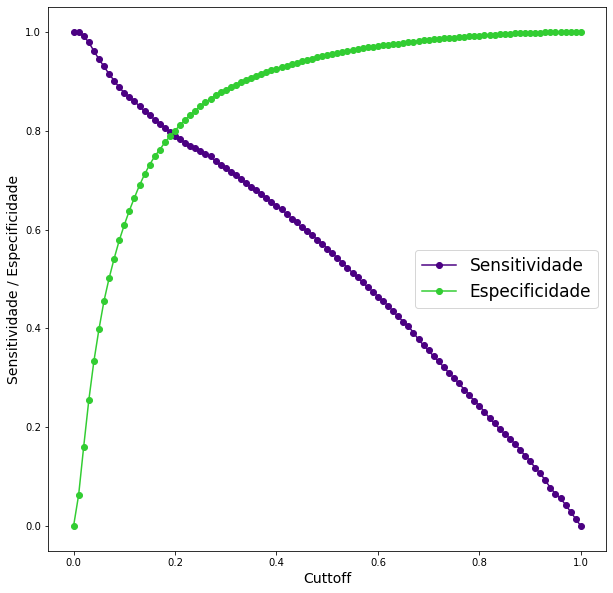

In [14]:
# In[ ]: Visualizando o novo dataframe 'dados_plotagem' e plotando os dados
#em um gráfico que mostra a variação da especificidade e da sensitividade
#em função do cutoff

plt.figure(figsize=(10,10))
plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, '-o',
         color='indigo')
plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, '-o',
         color='limegreen')
plt.legend(['Sensitividade', 'Especificidade'], fontsize=17)
plt.xlabel('Cuttoff', fontsize=14)
plt.ylabel('Sensitividade / Especificidade', fontsize=14)
plt.show()

# Fim